# Responses to the problem set
The following notebook documents my responses to the questions listed in problems.pdf

## Problem 1

MYD88 L265P is a common mutation in B cell lymphomas. A liquid biopsy found 5 of 1,000 molecules at the
locus have this mutant allele.

a) Mutant allele fraction (MAF) for this problem is 5/1000. Assuming the generation of mutants follows a binomial distribution, we could use the [wald interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
) or normal approximation to the binomial distribution to get the confidence interval for the MAF.

b) The standard deviation for the MAF is given below. If we acquired the same number of molecules, then we multiply N number of molecules by the MAF standard deviation to get its units in molecules.

The formula for the wald interval and answers to a and b are below:

In [1]:
p = MAF = 5/1000
n = 1000
std = (p*(1-p)/n)**0.5
z = 1.96 # z-score for 95% confidence interval around the mean p
p_low = p - z*std
p_high = p + z*std
print('MAF = p = ', p)
print('p_std = ',std)
print('z_score = ',z)
print('confidence interval = [',p_low,',',p_high,']')
print('n molecules = ',n)
print('std in molecules', std*n)

MAF = p =  0.005
p_std =  0.0022304708023195463
z_score =  1.96
confidence interval = [ 0.0006282772274536896 , 0.00937172277254631 ]
n molecules =  1000
std in molecules 2.2304708023195463


## Problem 2a
### Without providing a fix, identify at least one bug in what ChatGPT wrote.

`count_fragments.py` only examines the mutations contained in the first read. It completely ignores mutations the mate pair may also have. This would make sense if targeted sequencing was done and only read1 can align to the gene of interest. Here read2 may not contain any interesting information.

If shotgun sequencing was performed instead of targeted sequencing, there is a possibility both reads can align to the gene of interest and contain relevant mutation count information.

The code also does not address what happens if read1 and read2 overlap in the same region but disagree in what they say about the same bp position. This should be unlikely if the quality threshold is set high enough to filter out low quality reads.

When we are counting mutations in a sorted bam file, we are usually interested in knowing how many mutations are at each chromosome location or bin. This code assumes all reads are reporting mutations from roughly the same locus or chromosome location.

There is no option to filter for reads at a particular chromosome location. There is no warning about the assumptions this code is making. Examining the bam file with `samtools view example.bam` showed the reads were all aligning to roughly to the same chromosome location, which means it works as intended for this piece of data. However, you can never predict how a user could misuse this code because they forget the fine details about what sort of input data this code is suppose to take.

## Problem 2b
### Modify this function to be a script that can be called from a shell.

see `count_fragments_zc.py` for my modifications. I also added the ability to parse through multiple files and some exception handling incase files failed to open.

## Problem 2c
### Without implementing anything, discuss your preferred methods to ensure the accuracy and repeatability of this program as others use and modify it. Use 100 words or fewer.

To address the concerns I outlined in A above, I would write additional docstrings to detail what exactly is the kind of input data this code is ingesting and what assumptions it is making about the input data.

Next, a set of unittests are needed to check for basics like proper type handling, proper file handling, and other annoying edge cases that could come up in development. Ideally, this code should conform to the input and output rule conventions like in snakemake, where we have a file input and file output that can be passed to downstream operations. We would run the unittests with each build or version of the code to catch errors and patch them.

Finally, it helps to have someone else look at the code to provide feedback, simplify, improve performance, or add features.

All these pieces noted above help us robustly integrate this simple code into more complex pipelines.

## Problem 3a
Given an assay that detects 20 mutations, you want to classify patients that respond well to a new therapy. If the classifier were the number of mutations detected, what would be the best threshold if the specificity must be ≥ 90%? Using the provided data.csv file and the number of mutations detected as a classifier,what would be the best threshold if the specificity must be ≥ 90%?


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = pd.read_csv('data.csv')

# find mutations column
col = ['mut' in c for c in x.columns]
col = x.columns[col]

# get total mutations
x['mutations'] = 0
for c in col:
    x['mutations'] = x['mutations'] + (x[c] > 0)*1.0
x['mutations'] = x['mutations'].astype(int)
x_raw = x

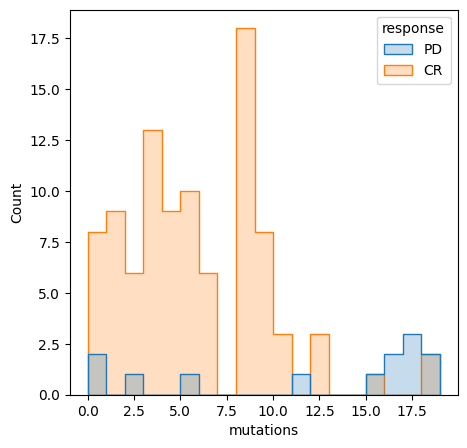

In [3]:
plt.figure(1, figsize=(5,5))
bins = np.arange(20)
sns.histplot(data=x_raw, x='mutations', hue='response', element='step', bins=bins)
plt.show()

We want to the classifier to have a specificity of 90% for patients that respond well to therapy. The histogram shows that lower number of mutations are correlated with complete response (CR), or responds well to therapy. We want to determine a threshold number of mutations such that 90% of the patients classified are true responders (CR) and the rest belong to the PD group.

Threshold mutation =  0
Sensitivity =  13 /( 88 + 13 ) =  0.12871287128712872
Specificity =  8 /( 8 + 2 ) =  0.8
Threshold mutation =  1
Sensitivity =  13 /( 79 + 13 ) =  0.14130434782608695
Specificity =  17 /( 17 + 2 ) =  0.8947368421052632
Threshold mutation =  2
Sensitivity =  12 /( 73 + 12 ) =  0.1411764705882353
Specificity =  23 /( 23 + 3 ) =  0.8846153846153846
Threshold mutation =  3
Sensitivity =  12 /( 60 + 12 ) =  0.16666666666666666
Specificity =  36 /( 36 + 3 ) =  0.9230769230769231
Threshold mutation =  4
Sensitivity =  12 /( 51 + 12 ) =  0.19047619047619047
Specificity =  45 /( 45 + 3 ) =  0.9375
Threshold mutation =  5
Sensitivity =  11 /( 41 + 11 ) =  0.21153846153846154
Specificity =  55 /( 55 + 4 ) =  0.9322033898305084
Threshold mutation =  6
Sensitivity =  11 /( 35 + 11 ) =  0.2391304347826087
Specificity =  61 /( 61 + 4 ) =  0.9384615384615385
Threshold mutation =  7
Sensitivity =  11 /( 35 + 11 ) =  0.2391304347826087
Specificity =  61 /( 61 + 4 ) =  0.938461538

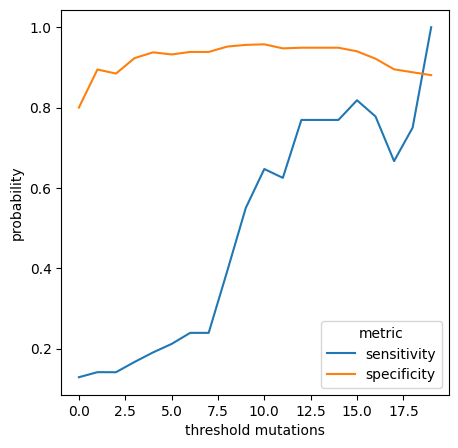

In [4]:
# iterate through mutation
out = []
for i in range(20):
    print('Threshold mutation = ',i)
    c = x['mutations'] > i
    cr = sum(x[c]['response'] == 'CR')
    pdd = sum(x[c]['response'] == 'PD')
    print('Sensitivity = ', pdd, '/(',cr,'+',pdd,') = ',pdd/(pdd+cr))
    sens = pdd/(pdd+cr)
    
    cr = sum(x[~c]['response'] == 'CR')
    pdd = sum(x[~c]['response'] == 'PD')
    print('Specificity = ', cr, '/(',cr,'+',pdd,') = ', cr/(pdd+cr))
    spec = cr/(pdd+cr)
    out.append([i, sens, spec])

col = ['threshold mutations','sensitivity','specificity']
df = pd.DataFrame(out, columns=col)

df1 = df.copy()
df1['probability']= df['sensitivity']
df1['metric'] = 'sensitivity'

df2 = df.copy()
df2['probability'] = df['specificity']
df2['metric'] = 'specificity'
col = ['threshold mutations','probability','metric']
df = pd.concat([df1[col], df2[col]])

plt.figure(2, figsize=(5,5))
sns.lineplot(data=df, x='threshold mutations', y='probability', hue='metric')
plt.show()

The list and graph above shows the trade off between sensitivity and specificity for th ande mutation threshold test. According to the table, we hit specificity greater than 90% for patients who respond to therapy at 3 or more mutations. This means for patients with less than 3 mutations, more than 90% will actually respond to therapy.

The sensitivity of the test for patients who do not respond to therapy is still quite low, less than 16% will actually have their disease get worse. However, in cancer diagnostics, you maybe prefer to err on the side of caution and continue to treat patients with more than 3 mutations in case their condition could get worse.

One problem with the dataset that could change these numbers is that read counts for some of the patients are quite low. Average read depth should be around 1000. There are a few patients who have insufficient read depth and this could mean the assay is unreliable for these patients and we should exclude them from the calculations. Filtering the table shows that these patients are classified as non-responders to therapy, yet have 0 recorded mutations. This would indeed throw off the threshold calculations if we did not exclude them.

In [5]:
print('average read depth = ', np.mean(x['depth']))
cols = ['sample_id','depth','response','mutations']
x[x['depth'] < 500][cols]

average read depth =  976.7747747747748


,sample_id,depth,response,mutations
44,sample_44,0,PD,0
94,sample_94,16,PD,0


Threshold mutation =  0
Sensitivity =  13 /( 88 + 13 ) =  0.12871287128712872
Specificity =  8 /( 8 + 0 ) =  1.0
sens + spec =  1.1287128712871288
Threshold mutation =  1
Sensitivity =  13 /( 79 + 13 ) =  0.14130434782608695
Specificity =  17 /( 17 + 0 ) =  1.0
sens + spec =  1.141304347826087
Threshold mutation =  2
Sensitivity =  12 /( 73 + 12 ) =  0.1411764705882353
Specificity =  23 /( 23 + 1 ) =  0.9583333333333334
sens + spec =  1.0995098039215687
Threshold mutation =  3
Sensitivity =  12 /( 60 + 12 ) =  0.16666666666666666
Specificity =  36 /( 36 + 1 ) =  0.972972972972973
sens + spec =  1.1396396396396398
Threshold mutation =  4
Sensitivity =  12 /( 51 + 12 ) =  0.19047619047619047
Specificity =  45 /( 45 + 1 ) =  0.9782608695652174
sens + spec =  1.168737060041408
Threshold mutation =  5
Sensitivity =  11 /( 41 + 11 ) =  0.21153846153846154
Specificity =  55 /( 55 + 2 ) =  0.9649122807017544
sens + spec =  1.176450742240216
Threshold mutation =  6
Sensitivity =  11 /( 35 + 11 

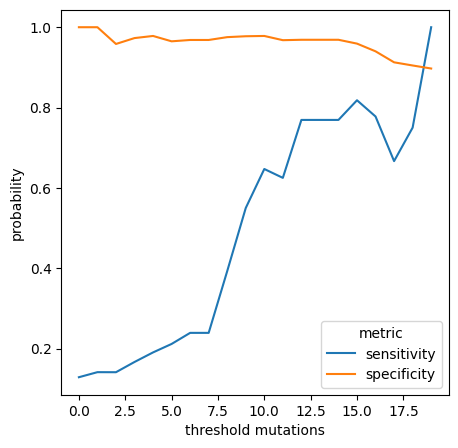

In [6]:
# iterate through mutation
x = x_raw[x_raw['depth'] > 500]
out = []
for i in range(20):
    print('Threshold mutation = ',i)
    c = x['mutations'] > i
    cr = sum(x[c]['response'] == 'CR')
    pdd = sum(x[c]['response'] == 'PD')
    
    print('Sensitivity = ', pdd, '/(',cr,'+',pdd,') = ',pdd/(pdd+cr))
    sens = pdd/(pdd+cr)
    
    cr = sum(x[~c]['response'] == 'CR')
    pdd = sum(x[~c]['response'] == 'PD')
    print('Specificity = ', cr, '/(',cr,'+',pdd,') = ', cr/(pdd+cr))
    spec = cr/(pdd+cr)
    out.append([i, sens, spec])
    print('sens + spec = ',sens+spec)

col = ['threshold mutations','sensitivity','specificity']
df = pd.DataFrame(out, columns=col)

df1 = df.copy()
df1['probability']= df['sensitivity']
df1['metric'] = 'sensitivity'

df2 = df.copy()
df2['probability'] = df['specificity']
df2['metric'] = 'specificity'
col = ['threshold mutations','probability','metric']
df = pd.concat([df1[col], df2[col]])

plt.figure(2, figsize=(5,5))
sns.lineplot(data=df, x='threshold mutations', y='probability', hue='metric')
plt.show()

By excluding the bad data points, we reach a new conclusion on the mutation threshold. Specificity steadily decreases as we increase the threshold mutation.

If we optimize for both sensitivity and specificity while keeping the constraint of 90% specificity, the most ideal position for setting the threshold would be 15+ mutations. Here, we have specificity of 95.9% and sensitivity of 81.8%. This means 95.9% of patients who are classified as complete responders actually are complete responders. 81.8% of patients classified as non-responders are true non-responders.

## Problem 3b
Without any additional analysis, discuss what you might do to improve the classification if you had data
for 1,000 patients and were not limited to a simple count of mutations. Use 100 words or fewer.



Some combinations of mutations could probably be a better prognostic marker for cancer than the total mutational load itself. Some mutations may also have more importance than others.

One way to figure this out would be to stratify the population and create classifiers for each sub-population that could have better specificity and sensitivity. We could do preliminary exploration if this is the case using tools like t-SNE or hierarchical clustering.

If we see certain mutations correlate more strongly with disease than total mutational load, this could be motivation to build more advanced classifiers like neural networks, which try to learn the importance weight for each gene or combination of genes.

The following example uses hierarchical clustering to group mutations and patients together in a 2D heatmap. Patients and genes indeed can be clustered together. From the dendrogram on the y-axis, there appears to be 5 major patient groups based on clustering of their mutant allele frequencies.

However, no obvious pattern as it relates to patient response can be seen. It is interesting to note from the heatmap that high frequency mutant alleles do not necessarily predict patient response. The drivers are likely some low frequency alleles or combinations thereof.

/tmp/ipykernel_2714712/1640923493.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sample'] = x['response']


<Figure size 1000x1000 with 0 Axes>

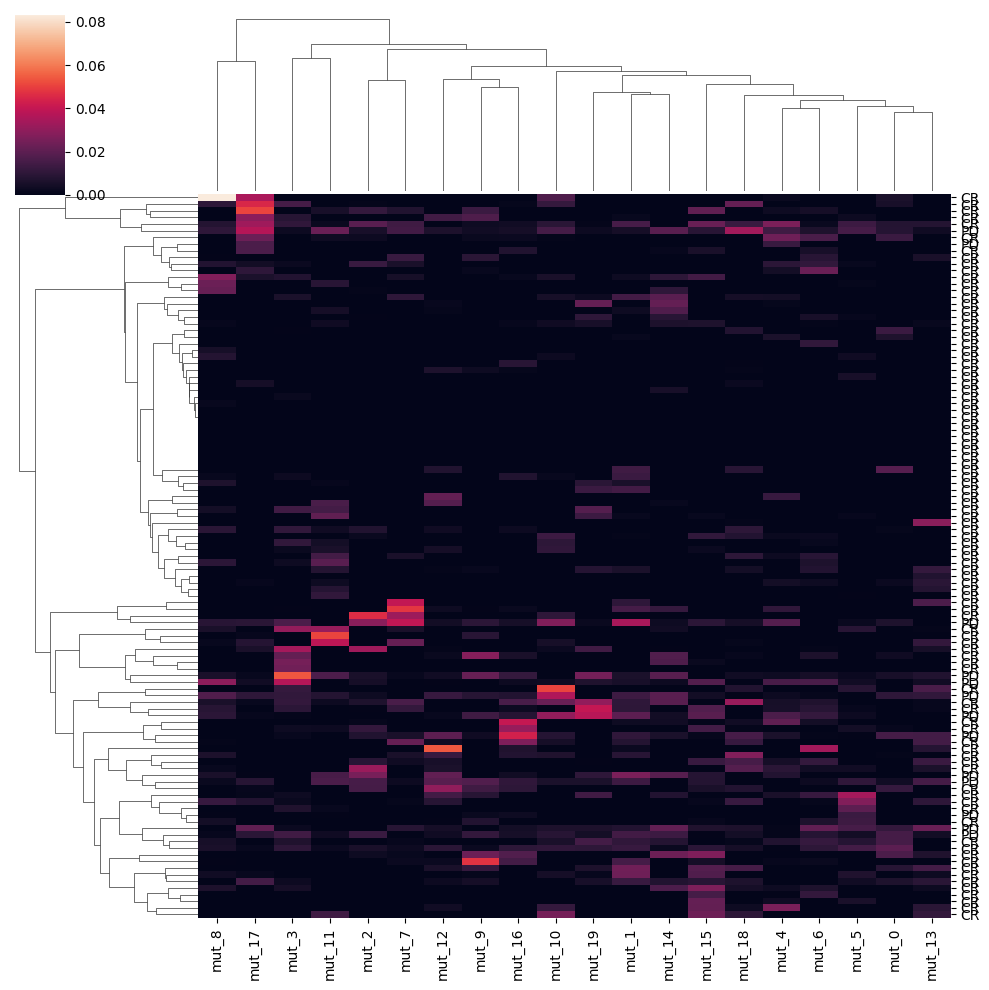

In [7]:
# remove bad data points
x = x_raw[x_raw['depth'] > 500]

# find mutations column
col = ['mut_' in c for c in x.columns]
col = x.columns[col]

plt.figure(1, figsize=(10,10))
x['sample'] = x['response']
ylabel = x['sample']
sns.clustermap(data=x[col], yticklabels=ylabel, method='ward')
plt.show()